https://data-dict.abcdstudy.org/?

In [1]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered


In [2]:
import statsmodels.api as sm

/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [42]:
import pandas as pd
import nilearn
import numpy as np
import glob 
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import jaccard_score
from sklearn.linear_model import LogisticRegression

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multitest import multipletests


from pathlib import Path

from scipy.stats import rankdata, ttest_rel, ttest_1samp

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import seaborn as sns

import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold



%matplotlib inline


In [4]:
basepath = '/Users/gracer/Library/CloudStorage/OneDrive-UniversityofWyoming/0. Lab/M2AENAD Lab - Documents/RESEARCH/ABCD/Yana_SSIB_2024/'

In [5]:
df = pd.read_csv(os.path.join(basepath,'data','matched111724_centered_dum.csv'))  

In [6]:
# Get number of subjects
n = df.shape[0]

In [8]:
nonBrain = [list(df.columns)[5], list(df.columns)[7] , list(df.columns)[-19],list(df.columns)[-15]]

In [10]:
ROIs = list(df.columns)[11:-23]

In [11]:
ROIS = nonBrain+ROIs

In [12]:
list(ROIS)

['demo_comb_income_v2',
 'interview_age',
 'bmi_perc',
 'sex_M',
 'rsfmri_c_ngd_ad_ngd_ca',
 'rsfmri_c_ngd_ad_ngd_dt',
 'rsfmri_c_ngd_ad_ngd_dla',
 'rsfmri_c_ngd_ad_ngd_fo',
 'rsfmri_c_ngd_ad_ngd_n',
 'rsfmri_c_ngd_ad_ngd_rspltp',
 'rsfmri_c_ngd_ad_ngd_smh',
 'rsfmri_c_ngd_ad_ngd_smm',
 'rsfmri_c_ngd_ad_ngd_sa',
 'rsfmri_c_ngd_ad_ngd_vta',
 'rsfmri_c_ngd_ad_ngd_vs',
 'rsfmri_c_ngd_cgc_ngd_ad',
 'rsfmri_c_ngd_cgc_ngd_cgc',
 'rsfmri_c_ngd_cgc_ngd_ca',
 'rsfmri_c_ngd_cgc_ngd_dt',
 'rsfmri_c_ngd_cgc_ngd_dla',
 'rsfmri_c_ngd_cgc_ngd_fo',
 'rsfmri_c_ngd_cgc_ngd_n',
 'rsfmri_c_ngd_cgc_ngd_rspltp',
 'rsfmri_c_ngd_cgc_ngd_smh',
 'rsfmri_c_ngd_cgc_ngd_smm',
 'rsfmri_c_ngd_cgc_ngd_sa',
 'rsfmri_c_ngd_cgc_ngd_vta',
 'rsfmri_c_ngd_cgc_ngd_vs',
 'rsfmri_c_ngd_ca_ngd_ad',
 'rsfmri_c_ngd_ca_ngd_cgc',
 'rsfmri_c_ngd_ca_ngd_ca',
 'rsfmri_c_ngd_ca_ngd_dt',
 'rsfmri_c_ngd_ca_ngd_dla',
 'rsfmri_c_ngd_ca_ngd_fo',
 'rsfmri_c_ngd_ca_ngd_n',
 'rsfmri_c_ngd_ca_ngd_rspltp',
 'rsfmri_c_ngd_ca_ngd_smh',
 'rsfmri_c

In [14]:
df['ssb_group'] = df['ssb_group'].replace({'low':0,'high':1})

In [15]:
X = df[ROIS] #features

In [16]:
X.shape

(3700, 418)

In [17]:
# Transpose the DataFrame to make columns become rows
X_T = X.T

duplicates = X_T.duplicated(keep='first')


In [18]:
# Identifying columns to drop (all duplicates except the first occurrence)
cols_to_drop = X_T[duplicates].index


In [19]:
# Drop the duplicate columns from the original DataFrame
X_cleaned = X.drop(cols_to_drop, axis=1)

print(X_cleaned)

      demo_comb_income_v2  interview_age  bmi_perc  sex_M  \
0                1.134865       2.208108 -0.074089      1   
1                1.134865      -3.791892 -0.166220      0   
2               -6.865135       2.208108 -0.117158      1   
3                0.134865      -0.791892  0.181997      0   
4               -3.865135      -0.791892  0.132754      0   
...                   ...            ...       ...    ...   
3695             0.134865       6.208108 -0.089739      1   
3696             1.134865      11.208108 -0.092898      0   
3697            -0.865135      -4.791892  0.209150      0   
3698             2.134865      12.208108  0.009343      1   
3699             1.134865       5.208108  0.314276      1   

      rsfmri_c_ngd_ad_ngd_ca  rsfmri_c_ngd_ad_ngd_dt  rsfmri_c_ngd_ad_ngd_dla  \
0                   0.043602               -0.052279                -0.001817   
1                   0.017131                0.052089                 0.004709   
2                   0.01

In [20]:
X.shape

(3700, 418)

In [21]:
X_cleaned.shape

(3700, 341)

# Factor of interest
This is sometimes called the target. Right now I am using sex, but eventually we will change this to SSB group

In [22]:
y = df['ssb_group'] #target

In [23]:
y.value_counts()

1    1850
0    1850
Name: ssb_group, dtype: int64

# Train and test datasets
Get randomly generated train and test datasets
- Train 1 = train the model and feature elimination
- Train 2 = cross validate the model
- Test = test statistical differences

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, random_state=42)


In [25]:
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, random_state=42)
X_test.shape
y_test.value_counts()

In [30]:
anova_filter = SelectKBest(f_classif)
svm = SVC(kernel='linear')

anova_svm = Pipeline([
    ('anova', anova_filter),
    ('svc', svm)
])
# Define a range of parameters for feature selection and SVM
param_grid = {
    'anova__k': [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60],  # Trying different numbers of top features
    'svc__C': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15],  # SVM regularization parameter
}

# Setup GridSearchCV
grid_search = GridSearchCV(anova_svm, param_grid=param_grid, cv=10, n_jobs=4)
grid_search.fit(X_train1, y_train1)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('anova', SelectKBest()),
                                       ('svc', SVC(kernel='linear'))]),
             n_jobs=4,
             param_grid={'anova__k': [50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
                                      60],
                         'svc__C': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11,
                                    0.12, 0.13, 0.14, 0.15]})

In [34]:
bestK = []
bestC = []
bestModel = []
for i in range(49):
    print(i)
    #Setup GridSearchCV
    grid_search = GridSearchCV(anova_svm, param_grid=param_grid, cv=10, n_jobs=4)
    bestModel.append(grid_search)
    grid_search.fit(X_train1, y_train1)
    bestK.append(grid_search.best_params_['anova__k'])
    bestC.append(grid_search.best_params_['svc__C'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


## Initial
* anova_initial = [10,20,30,40,50,60]
* svc_C_initial = [0.1, 1, 10, 100]
* Then narrowed to anova 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60
* svc c 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15
## First try
* Best parameters: {'anova__k': 51, 'svc__C': 0.15}
* Best cross-validation score: 0.5530157342657344## Second try
## 48 iterations 
* Best parameters: {'anova__k': 50, 'svc__C': 0.05}
* Best cross-validation score: 0.7112026131762974
# Note
the model is much better with nonBrain regions. But still better than chance
* Best parameters: {'anova__k': 52, 'svc__C': 0.12}
* Best cross-validation score: 0.5713424733161576

## Check the best parameters

In [ ]:
print(bestK)
print(bestC)
# Find the best and then select the model from the bestModel list

In [39]:
print(grid_search.best_params_)

{'anova__k': 50, 'svc__C': 0.05}


In [40]:
# Assuming anova_svm is your original pipeline
best_pipeline = Pipeline([
    ('anova', SelectKBest(f_classif)),  # You don't need to specify k here; it will be set by best_params_
    ('svc', SVC(kernel='linear'))      # No need to specify C here for the same reason
])

# Set the best parameters found for the entire pipeline
best_pipeline.set_params(**grid_search.best_params_)

# Now, retrain on the entire training set with the best parameters
best_pipeline.fit(X_train1, y_train1)

Pipeline(steps=[('anova', SelectKBest(k=50)),
                ('svc', SVC(C=0.05, kernel='linear'))])

In [43]:
# Predict on the test set
y_pred = best_pipeline.predict(X_train2)

# Evaluate the model
test_accuracy = accuracy_score(y_train2, y_pred)
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.7348703170028819


In [44]:
cm = confusion_matrix(y_train2, y_pred, normalize = 'true')
print(cm)

[[0.87215909 0.12784091]
 [0.40643275 0.59356725]]


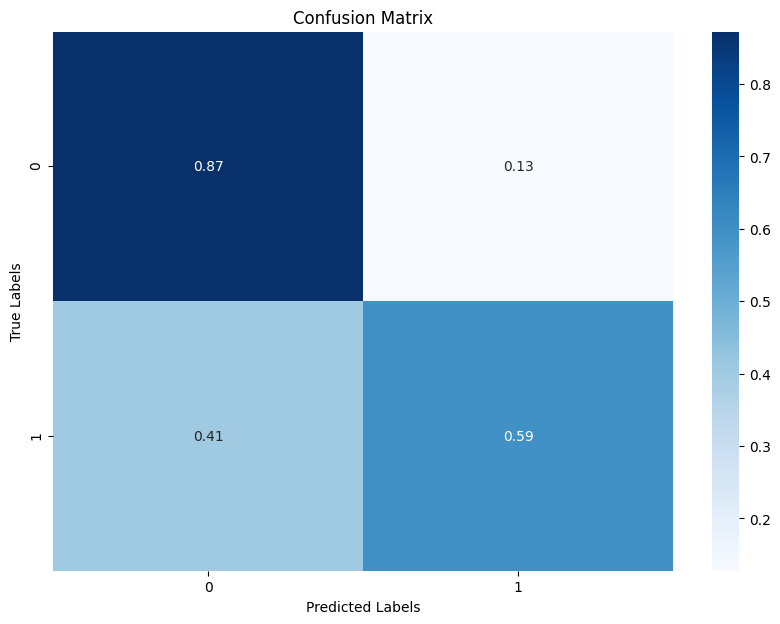

In [45]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True,  cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [46]:
# Access the best set of parameters found by GridSearchCV
best_parameters = grid_search.best_params_
print("Best parameters found by GridSearchCV:", best_parameters)

# Access the best estimator directly
best_model = grid_search.best_estimator_
print("Best model:", best_model)


Best parameters found by GridSearchCV: {'anova__k': 50, 'svc__C': 0.05}
Best model: Pipeline(steps=[('anova', SelectKBest(k=50)),
                ('svc', SVC(C=0.05, kernel='linear'))])


In [47]:
# Access the feature selection step ('anova' in your case)
feature_selection_step = best_model.named_steps['anova']


In [48]:
# Get the mask of selected features (boolean array)
selected_features_mask = feature_selection_step.get_support()



In [49]:
selected_features_mask.shape

(341,)

In [50]:
selected_columns = X_train.columns[selected_features_mask]


In [51]:
selected_columns

Index(['demo_comb_income_v2', 'interview_age', 'bmi_perc', 'sex_M',
       'rsfmri_c_ngd_ad_ngd_vs', 'rsfmri_c_ngd_cgc_ngd_ad',
       'rsfmri_c_ngd_cgc_ngd_cgc', 'rsfmri_c_ngd_smh_ngd_smm',
       'rsfmri_c_ngd_sa_ngd_vta', 'rsfmri_cor_ngd_au_scs_aalh',
       'rsfmri_cor_ngd_au_scs_ptrh', 'rsfmri_cor_ngd_au_scs_vtdcrh',
       'rsfmri_cor_ngd_cerc_scs_cdelh', 'rsfmri_cor_ngd_cerc_scs_ptlh',
       'rsfmri_cor_ngd_cerc_scs_aglh', 'rsfmri_cor_ngd_cerc_scs_vtdclh',
       'rsfmri_cor_ngd_cerc_scs_hprh', 'rsfmri_cor_ngd_cerc_scs_agrh',
       'rsfmri_cor_ngd_cerc_scs_vtdcrh', 'rsfmri_cor_ngd_copa_scs_thplh',
       'rsfmri_cor_ngd_copa_scs_vtdclh', 'rsfmri_cor_ngd_copa_scs_crcxrh',
       'rsfmri_cor_ngd_copa_scs_plrh', 'rsfmri_cor_ngd_df_scs_ptlh',
       'rsfmri_cor_ngd_df_scs_pllh', 'rsfmri_cor_ngd_df_scs_aalh',
       'rsfmri_cor_ngd_none_scs_ptlh', 'rsfmri_cor_ngd_none_scs_thprh',
       'rsfmri_cor_ngd_none_scs_cderh', 'rsfmri_cor_ngd_rst_scs_bs',
       'rsfmri_cor_ngd_rst_scs_crc

# Regression

In [52]:
from sklearn.linear_model import LogisticRegression

In [53]:
X_regression = X_test[selected_columns]

## Check high correlations between regions

In [54]:
correlation_matrix = X_regression.corr()


In [55]:
# Set the threshold for high correlation
threshold = 0.8

# Create a boolean mask for values above the threshold
high_corr_mask = np.abs(correlation_matrix) > threshold

# Mask the diagonal and lower triangle
mask_upper_triangle = np.triu(np.ones(high_corr_mask.shape), k=1).astype(np.bool)

# Combine masks
final_mask = high_corr_mask & mask_upper_triangle

/var/folders/02/zfp2v0gd46j44wl8qx8jxjtr0000gn/T/ipykernel_38515/3020619189.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_upper_triangle = np.triu(np.ones(high_corr_mask.shape), k=1).astype(np.bool)


In [56]:
# Apply mask to the correlation matrix
high_corr_pairs = correlation_matrix.where(final_mask)

# Stack the matrix and reset index to get pair-wise correlation in a readable format
stacked_corr_pairs = high_corr_pairs.stack().reset_index()
stacked_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

print(stacked_corr_pairs)

                        Feature 1                      Feature 2  Correlation
0      rsfmri_cor_ngd_au_scs_ptrh  rsfmri_cor_ngd_rst_scs_crcxrh     0.822824
1    rsfmri_cor_ngd_cerc_scs_aglh    rsfmri_cor_ngd_smh_scs_pllh     0.858514
2    rsfmri_cor_ngd_cerc_scs_hprh   rsfmri_cor_ngd_smh_scs_cderh     0.867641
3    rsfmri_cor_ngd_cerc_scs_agrh    rsfmri_cor_ngd_smh_scs_ptrh     0.831211
4  rsfmri_cor_ngd_cerc_scs_vtdcrh    rsfmri_cor_ngd_smh_scs_hprh     0.815776
5   rsfmri_cor_ngd_copa_scs_thplh    rsfmri_cor_ngd_smh_scs_aarh     0.877435
6  rsfmri_cor_ngd_copa_scs_vtdclh    rsfmri_cor_ngd_smm_scs_hplh     0.864477
7  rsfmri_cor_ngd_copa_scs_crcxrh    rsfmri_cor_ngd_smm_scs_aglh     0.805186


|#|feature 1|feature 2|r|
|---|-------------------------------|--------------------------------|--------------|
| 0  |    rsfmri_cor_ngd_au_scs_ptrh |  rsfmri_cor_ngd_rst_scs_crcxrh |    0.822824  |
| 1 |  rsfmri_cor_ngd_cerc_scs_aglh |   rsfmri_cor_ngd_smh_scs_pllh  |     0.858514 |
| 2 |    rsfmri_cor_ngd_cerc_scs_hprh|   rsfmri_cor_ngd_smh_scs_cderh|      0.867641|
| 3 |    rsfmri_cor_ngd_cerc_scs_agrh|     rsfmri_cor_ngd_smh_scs_ptrh|      0.831211| 
|  4  | rsfmri_cor_ngd_cerc_scs_vtdcrh  |   rsfmri_cor_ngd_smh_scs_hprh  |    0.815776| 
| 5|   rsfmri_cor_ngd_copa_scs_thplh |    rsfmri_cor_ngd_smh_scs_aarh  |    0.877435| 
|  6  | rsfmri_cor_ngd_copa_scs_vtdclh  |   rsfmri_cor_ngd_smm_scs_hplh  |    0.864477| 
|  7 |  rsfmri_cor_ngd_copa_scs_crcxrh  |   rsfmri_cor_ngd_smm_scs_aglh   |   0.805186| 

|ABCD|Human|
|---|----|
|rsfmri_cor_ngd_au_scs_ptrh|	Average correlation between auditory network and ASEG ROI right-putamen|
| rsfmri_cor_ngd_cerc_scs_aglh| Average correlation between cingulo-opercular network and ASEG ROI left-amygdala|
|rsfmri_cor_ngd_cerc_scs_hprh|cingulo-opercular network and ASEG ROI right-hippocampus	|
|rsfmri_cor_ngd_cerc_scs_vtdcrh| cingulo-opercular network and ASEG ROI right-ventraldc|
|rsfmri_cor_ngd_copa_scs_thplh|cingulo-parietal network and ASEG ROI left-thalamus-proper|
|rsfmri_cor_ngd_copa_scs_crcxrh |cingulo-parietal network and ASEG ROI right-cerebellum-cortex|
|sfmri_cor_ngd_rst_scs_crcxrh|retrosplenial temporal network and ASEG ROI right-cerebellum-cortex|
|rsfmri_cor_ngd_smh_scs_pllh|Average correlation between sensorimotor hand network and ASEG ROI left-pallidum|
|rsfmri_cor_ngd_smh_scs_cderh|Average correlation between sensorimotor hand network and ASEG ROI right-caudate|
|rsfmri_cor_ngd_smh_scs_hprh|sensorimotor hand network and ASEG ROI right-hippocampus|
|sfmri_cor_ngd_smh_scs_aarh	|sensorimotor hand network and ASEG ROI right-accumbens-area|
|rsfmri_cor_ngd_smm_scs_aglh|sensorimotor mouth network and ASEG ROI left-amygdala|

In [57]:
# Dropping cerebellar first
columns_to_drop_list = ['rsfmri_cor_ngd_rst_scs_crcxrh','rsfmri_cor_ngd_copa_scs_crcxrh']

X_regression_reduced = X_regression.drop(columns=columns_to_drop_list)



In [58]:
# Assuming X_scaled is your scaled feature matrix and it's a numpy array
#X_scaled_df = pd.DataFrame(X_scaled, columns=X_test_reg_sm.columns)  # Convert to DataFrame if necessary
#X_scaled_df_with_const = sm.add_constant(X_scaled_df)  # Add constant for VIF calculation

vifs = pd.Series([variance_inflation_factor(X_regression_reduced.values, i) 
                   for i in range(X_regression_reduced.shape[1])], 
                  index=X_regression_reduced.columns)

print(vifs) # looks OK, everything is under 10

demo_comb_income_v2               1.244999
interview_age                     1.072335
bmi_perc                          1.137007
sex_M                             1.086619
rsfmri_c_ngd_ad_ngd_vs            1.592855
rsfmri_c_ngd_cgc_ngd_ad           2.722862
rsfmri_c_ngd_cgc_ngd_cgc          2.223601
rsfmri_c_ngd_smh_ngd_smm          1.946571
rsfmri_c_ngd_sa_ngd_vta           1.505130
rsfmri_cor_ngd_au_scs_aalh        2.456463
rsfmri_cor_ngd_au_scs_ptrh        4.515201
rsfmri_cor_ngd_au_scs_vtdcrh      2.087120
rsfmri_cor_ngd_cerc_scs_cdelh     3.946059
rsfmri_cor_ngd_cerc_scs_ptlh      3.709819
rsfmri_cor_ngd_cerc_scs_aglh      7.711133
rsfmri_cor_ngd_cerc_scs_vtdclh    1.210645
rsfmri_cor_ngd_cerc_scs_hprh      6.784987
rsfmri_cor_ngd_cerc_scs_agrh      5.261866
rsfmri_cor_ngd_cerc_scs_vtdcrh    4.022071
rsfmri_cor_ngd_copa_scs_thplh     6.482789
rsfmri_cor_ngd_copa_scs_vtdclh    5.591059
rsfmri_cor_ngd_copa_scs_plrh      2.830012
rsfmri_cor_ngd_df_scs_ptlh        2.306804
rsfmri_cor_

In [60]:
result_sm = sm.add_constant(X_regression_reduced)

/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


# Create train, test datasets for regression

In [61]:
X_trainReg, X_testReg, y_trainReg, y_testReg = train_test_split(result_sm, y_test, random_state=42)


In [62]:
X_testReg.shape

(232, 49)

In [63]:
selected_columns =X_trainReg.columns

In [64]:
# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

In [65]:
# Fit the model on the training data
model.fit(X_trainReg, y_trainReg)

LogisticRegression(max_iter=1000)

In [66]:
# Predict on the test set
y_predReg = model.predict(X_testReg)

# Calculate the accuracy
accuracyReg = accuracy_score(y_testReg, y_predReg)
print(f"Accuracy: {accuracyReg}")


Accuracy: 0.6939655172413793


In [67]:
# Coefficients
coefficients = model.coef_
# Intercepts
intercepts = model.intercept_

In [68]:
coeff_df = pd.DataFrame(coefficients, columns=selected_columns)


In [69]:
coeff_df['Intercept'] = intercepts

In [70]:
class_names = ['low']  # Adjust as per your classes
coeff_df.index = class_names

print(coeff_df)


        const  demo_comb_income_v2  interview_age  bmi_perc     sex_M  \
low -0.005417            -0.781189       0.055197  0.470392  0.388404   

     rsfmri_c_ngd_ad_ngd_vs  rsfmri_c_ngd_cgc_ngd_ad  \
low                0.524525                 0.113052   

     rsfmri_c_ngd_cgc_ngd_cgc  rsfmri_c_ngd_smh_ngd_smm  \
low                 -0.527866                   0.72845   

     rsfmri_c_ngd_sa_ngd_vta  ...  rsfmri_cor_ngd_smm_scs_aglh  \
low                 0.322597  ...                     0.148545   

     rsfmri_cor_ngd_smm_scs_thprh  rsfmri_cor_ngd_sa_scs_crcxlh  \
low                     -0.215582                     -0.184205   

     rsfmri_cor_ngd_sa_scs_thplh  rsfmri_cor_ngd_vta_scs_hplh  \
low                    -0.160271                     0.059097   

     rsfmri_cor_ngd_vs_scs_hplh  rsfmri_cor_ngd_vs_scs_thprh  \
low                    0.160113                    -0.465774   

     rsfmri_cor_ngd_vs_scs_plrh  rsfmri_cor_ngd_vs_scs_hprh  Intercept  
low                 

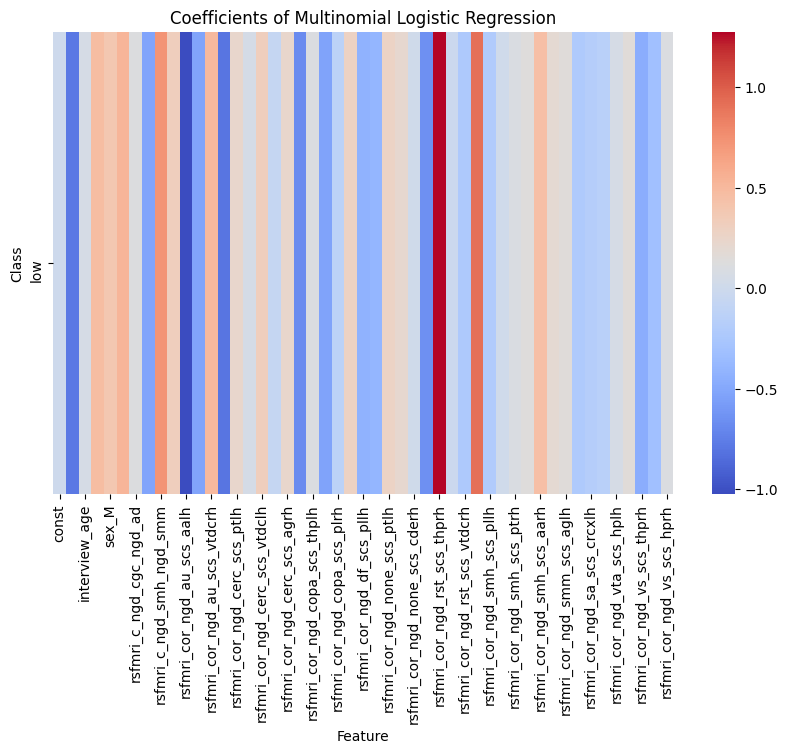

In [71]:
plt.figure(figsize=(10, 6))
sns.heatmap(coeff_df.iloc[:, :-1], annot=False, cmap='coolwarm')  # Exclude intercepts for visualization
plt.title('Coefficients of Multinomial Logistic Regression')
plt.ylabel('Class')
plt.xlabel('Feature')
plt.show()

In [72]:
# Fit the multinomial logistic regression model
logit_model = sm.Logit(y_testReg, X_testReg)
result = logit_model.fit()
#model_sm = sm.MNLogit(y_testReg, X_test_reg_sm)
#result_sm = model_sm.fit(method='newton', maxiter=5000)
# Summary of the model
# print(result_sm.summary())
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.428232
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              ssb_group   No. Observations:                  232
Model:                          Logit   Df Residuals:                      183
Method:                           MLE   Df Model:                           48
Date:                Tue, 19 Nov 2024   Pseudo R-squ.:                  0.3819
Time:                        11:18:32   Log-Likelihood:                -99.350
converged:                       True   LL-Null:                       -160.73
Covariance Type:            nonrobust   LLR p-value:                 1.787e-08
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.0603      0.311     -0.194     

In [76]:
# Making predictions
predictions = result.predict(X_testReg)

# Converting probabilities to class labels
class_predictions = np.where(predictions > 0.5, 1, 0)

In [79]:
array = y_testReg.to_numpy()

In [80]:
dfPrevReal = pd.DataFrame({'real': array, 'pred': class_predictions})

In [82]:
jaccard = jaccard_score(dfPrevReal['real'], dfPrevReal['pred'])
print("Jaccard Similarity Score:", jaccard)

Jaccard Similarity Score: 0.6212121212121212


In [83]:
# Extract p-values for all coefficients in the model
p_values = result.pvalues

In [84]:
result.pvalues

const                             8.459923e-01
demo_comb_income_v2               8.996283e-07
interview_age                     3.826282e-01
bmi_perc                          8.280450e-02
sex_M                             2.228070e-01
rsfmri_c_ngd_ad_ngd_vs            8.040992e-01
rsfmri_c_ngd_cgc_ngd_ad           7.126159e-01
rsfmri_c_ngd_cgc_ngd_cgc          3.021206e-01
rsfmri_c_ngd_smh_ngd_smm          5.229689e-01
rsfmri_c_ngd_sa_ngd_vta           5.637830e-01
rsfmri_cor_ngd_au_scs_aalh        1.965349e-01
rsfmri_cor_ngd_au_scs_ptrh        6.259573e-01
rsfmri_cor_ngd_au_scs_vtdcrh      4.460617e-01
rsfmri_cor_ngd_cerc_scs_cdelh     3.132491e-01
rsfmri_cor_ngd_cerc_scs_ptlh      6.188473e-01
rsfmri_cor_ngd_cerc_scs_aglh      4.047473e-01
rsfmri_cor_ngd_cerc_scs_vtdclh    4.784918e-01
rsfmri_cor_ngd_cerc_scs_hprh      3.542967e-01
rsfmri_cor_ngd_cerc_scs_agrh      5.790313e-01
rsfmri_cor_ngd_cerc_scs_vtdcrh    1.903321e-01
rsfmri_cor_ngd_copa_scs_thplh     8.269350e-01
rsfmri_cor_ng

In [85]:
# Apply Benjamini-Hochberg FDR correction
reject, pvals_corrected, _, _ = multipletests(p_values.values.flatten(), alpha=0.05, method='fdr_bh')

# Reshape the corrected p-values to match the original shape
pvals_corrected_reshaped = pvals_corrected.reshape(p_values.shape)

# Create a DataFrame of the corrected p-values for easier interpretation
# corrected_pvalues_df = pd.DataFrame(pvals_corrected_reshaped, index=p_values.index, columns=p_values.columns)

In [86]:
pvals_corrected_reshaped

array([9.56949113e-01, 4.40817873e-05, 8.76340189e-01, 6.47617173e-01,
       8.76340189e-01, 9.56949113e-01, 9.15112787e-01, 8.76340189e-01,
       8.76340189e-01, 8.76340189e-01, 8.76340189e-01, 8.76340189e-01,
       8.76340189e-01, 8.76340189e-01, 8.76340189e-01, 8.76340189e-01,
       8.76340189e-01, 8.76340189e-01, 8.76340189e-01, 8.76340189e-01,
       9.56949113e-01, 5.78662011e-01, 8.76340189e-01, 8.76340189e-01,
       9.15112787e-01, 6.47617173e-01, 9.15112787e-01, 8.76340189e-01,
       8.76340189e-01, 5.78662011e-01, 8.76340189e-01, 9.80803448e-01,
       8.88689401e-01, 9.89202814e-01, 9.56949113e-01, 8.76340189e-01,
       8.76340189e-01, 8.76340189e-01, 8.76340189e-01, 6.47617173e-01,
       9.56949113e-01, 9.88433964e-01, 9.69070497e-01, 8.76340189e-01,
       8.76340189e-01, 6.47617173e-01, 8.76340189e-01, 8.76340189e-01,
       9.89202814e-01])